# Livrable 2 - Fully connected autoencoder

 ## Traitement des images
 ### Initialisation de l'environnement

In [ ]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
import os
import shutil
import zipfile
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.models import Sequential
import py7zr
from onedrivedownloader import download

# Set CUDA devices
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2024-10-17 23:18:40.360859: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 23:18:40.374125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 23:18:40.377840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 23:18:40.388741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 23:18:41.075703: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1729199921.705084  151163 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729199921.750141  151163 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729199921.753984  151163 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729199921.759213  151163 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Téléchargement des données

In [ ]:
def download_data(url, filename):
    """Download a file from a given URL."""
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        f.write(response.content)

# Define file paths
filename = 'dataset/Dataset.7z'
folder_to_extract = 'Dataset-L2'
extract_to_path = './dataset_L2'

# Check if the dataset directory exists
if not os.path.exists('./dataset'):
    # URL to download the dataset
    url = 'https://viacesifr-my.sharepoint.com/:u:/g/personal/arslane_ouldslimane_viacesi_fr/EYxF-OL6MXVIqY_Jps7fpGMBLUZzrsJajUZ3jHzgImkp_w?e=rvtSN6'
    download_data(url, filename)

# Extract the dataset
if not os.path.exists(extract_to_path):
    with py7zr.SevenZipFile(filename, 'r') as archive:
        all_files = archive.getnames()
        files_to_extract = [f for f in all_files if f.startswith(folder_to_extract)]
        archive.extract(path=extract_to_path, targets=files_to_extract)

# Remove the downloaded file
if os.path.exists(filename):
    os.remove(filename)

### Nettoyage des données

In [ ]:
from images_check import clean_dataset

# Clean dataset if not already done
if not os.path.exists('dataset_L2_clean/'):
    input_path = 'dataset_L2/'
    output_path = 'dataset_L2_clean/'
    clean_dataset(input_path, output_path)

### Prétraitement des images

In [ ]:
# Define image dimensions and batch size
image_w, image_h = 128, 128
batch_size = 64
dir_path = './dataset_L2_clean/'

# Load dataset without class labels
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_path,
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_size,
    label_mode=None,
    shuffle=False,
)

# Normalize images
def preprocess(image):
    return image / 255.0

dataset = dataset.map(preprocess)

Found 148 files.


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

In [ ]:
# augment the dataset
for i in range(3):
    augmented_dataset = dataset.map(lambda x: data_augmentation(x))
    dataset = dataset.concatenate(augmented_dataset)

In [ ]:
dataset.cardinality().numpy()

24

### Séparation du jeu de données

In [ ]:
# Put noise in the images put not the same amount of noise in all images if same_noise is False
def add_noise(images, noise_factor=0.3, same_noise=True):
    if same_noise:
        noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
    else:
        noise_factor = tf.random.uniform(shape=[], minval=0.2, maxval=0.5)
        noisy_images = images + noise_factor * tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=1.0)
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images

In [ ]:
def split_dataset(dataset, split=0.2):
    """Split the dataset into training and testing sets."""
    test_size = int(len(dataset) * split)
    train_size = len(dataset) - test_size
    
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size)
    
    return train_dataset, test_dataset

train_set, test_set = split_dataset(dataset, split=0.2)

In [ ]:
train_set.cardinality().numpy(), test_set.cardinality().numpy()

(20, 4)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
noisy_train_set = train_set.map(lambda x: (add_noise(x, 0.3), x))
noisy_test_set = test_set.map(lambda x: (add_noise(x, 0.3), x))

### Affichage des images

2024-10-17 23:18:45.582770: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


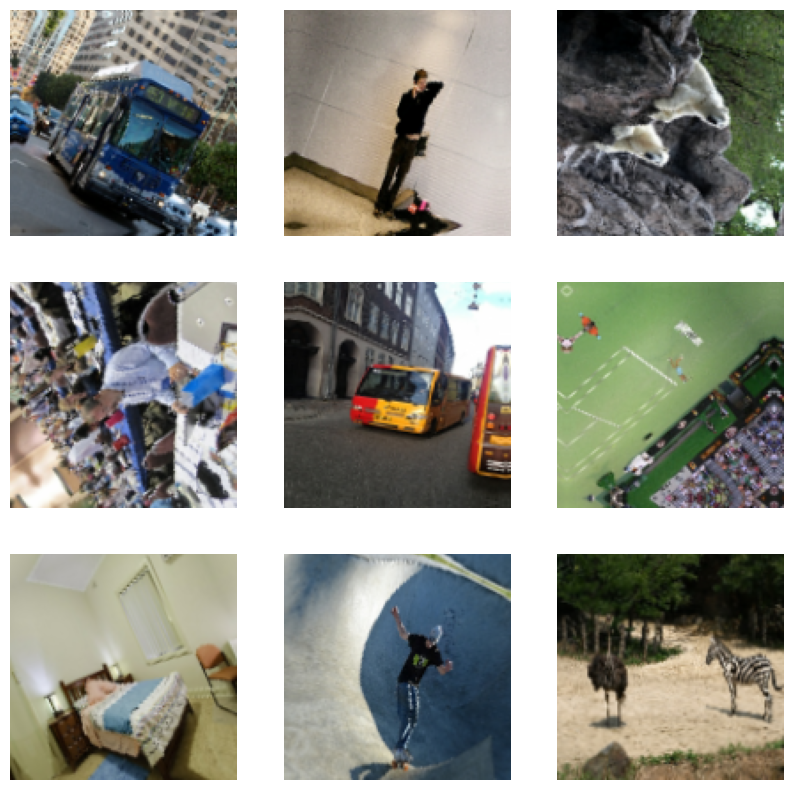

2024-10-17 23:18:46.012363: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


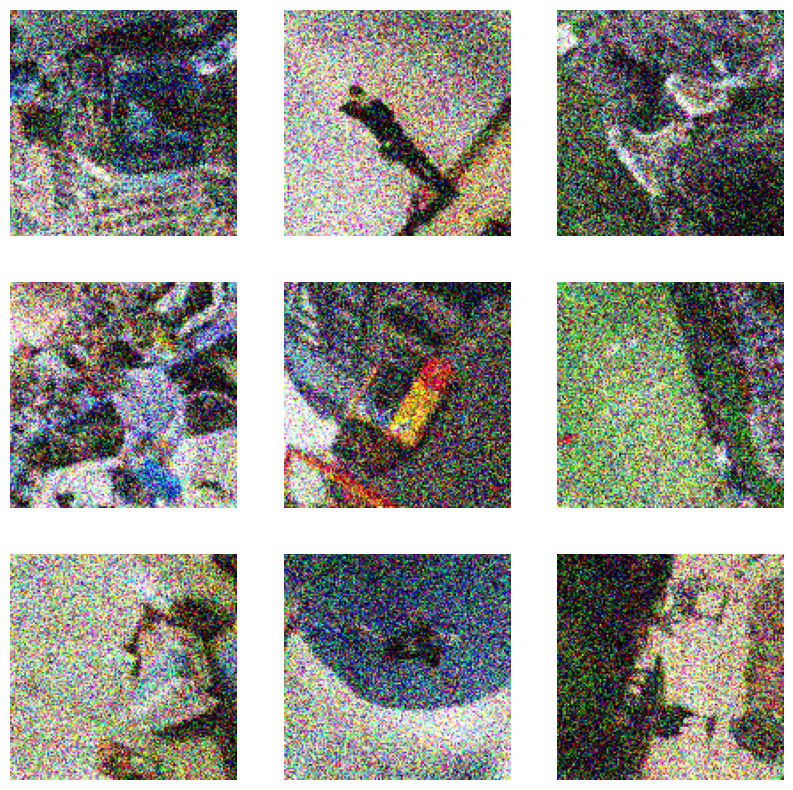

In [ ]:
# Displaying images from train_set
plt.figure(figsize=(10, 10))
for images in train_set.take(1):  # Take one batch from the train_set
    for i in range(min(9, len(images))):  # Ensure at least 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # Directly use images[i]
        plt.axis("off")
plt.show()  # Show the plot

plt.figure(figsize=(10, 10))
for images, _ in noisy_train_set.take(1):  # Take one batch from the train_set
    for i in range(min(9, len(images))):  # Ensure at least 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])  # Directly use images[i]
        plt.axis("off")
plt.show()  # Show the plot

## Fully connected autoencoder

A fully connected autoencoder is a type of neural network used to compress and reconstruct data, typically in scenarios where the data is relatively small and structured, such as image denoising tasks. It consists of two main parts: the encoder and the decoder. The encoder reduces the input data (in this case, an image) into a compressed lower-dimensional representation, while the decoder reconstructs the data back to its original form from the compressed version. Unlike convolutional autoencoders, which are specialized for handling image data, fully connected autoencoders treat the image as a flat vector.

In a fully connected autoencoder, the input image is first flattened into a one-dimensional array before passing through several dense layers in the encoder. Each layer reduces the dimensionality until the data is represented by a small latent space. The decoder then uses dense layers to reconstruct the original image from the latent space, gradually increasing the dimensionality back to the image's original size. The model is trained using a loss function (such as the combined SSIM and L1 loss in your case) that compares the original and reconstructed images and optimizes the network to minimize the difference.

One of the main advantages of fully connected autoencoders is their simplicity and ease of implementation. They are relatively straightforward, making them a good starting point for learning how autoencoders function. Since these models use dense (fully connected) layers, they can be applied to a wide range of data types, not just images. This flexibility makes fully connected autoencoders versatile tools for dimensionality reduction and reconstruction tasks in various domains. Additionally, they can be effective when working with smaller datasets, where more complex models might risk overfitting due to their higher number of parameters.

However, fully connected autoencoders struggle with image data, as they do not consider the spatial structure of images. When an image is flattened into a one-dimensional vector, the relationship between neighboring pixels is lost, leading to inefficiency in handling image patterns. This can result in poor performance, particularly in tasks like image denoising or reconstruction, where preserving spatial information is crucial. Moreover, these models can become computationally expensive as input sizes grow, due to the high number of parameters needed for full connections between neurons. In comparison to convolutional autoencoders, which are designed to handle image data more efficiently by leveraging local pixel relationships, fully connected autoencoders are often less effective and harder to scale for larger datasets.

In [ ]:
input_shape = (image_h, image_w, 3)

# Encoder
encoder = Sequential()
encoder.add(layers.Flatten(input_shape=input_shape))
encoder.add(layers.Dense(128, activation='relu'))
encoder.add(layers.Dense(64, activation='relu'))
encoder.add(layers.Dense(32, activation='relu'))
encoder.summary()

# Decoder
decoder = Sequential()
decoder.add(layers.Dense(64, activation='relu', input_shape=(32,)))
decoder.add(layers.Dense(128, activation='relu'))
decoder.add(layers.Dense(128*128*3, activation='sigmoid'))
decoder.add(layers.Reshape((128, 128, 3)))

decoder.summary()

# Autoencoder
autoencoder_input = layers.Input(shape=input_shape)
encoded_output = encoder(autoencoder_input)  # Pass input through encoder
decoded_output = decoder(encoded_output)      # Pass encoder output through decoder

# Create the complete autoencoder model
autoencoder = Model(inputs=autoencoder_input, outputs=decoded_output)

# Summary of the autoencoder model
autoencoder.summary()

/home/arslane/Documents/CESI/DataScience/projet/data_science_project/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,301,920 (24.04 MB)

 Trainable params: 6,301,920 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

/home/arslane/Documents/CESI/DataScience/projet/data_science_project/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 49152)          │     6,340,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 128, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,351,040 (24.23 MB)

 Trainable params: 6,351,040 (24.23 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 32)             │     6,301,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 128, 128, 3)    │     6,351,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,652,960 (48.27 MB)

 Trainable params: 12,652,960 (48.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def ssim_loss(y_true, y_pred):
    # Compute the SSIM loss
    SSIM = tf.image.ssim(y_true, y_pred, max_val=1.0) #, filter_size=(image_h//(2**4)))
    # SSIM is in the range [0, 1], so we return 1 - SSIM as the loss
    return 1 - SSIM

def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def combined_loss(y_true, y_pred):
    return ssim_loss(y_true, y_pred) + l1_loss(y_true, y_pred)

def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)  # Assuming image pixel values are normalized between 0 and 1

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)  # Assuming image pixel values are normalized between 0 and 1

def l1_metric(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

autoencoder.compile(optimizer='adam', loss=combined_loss, metrics=[psnr_metric, ssim_metric, l1_metric])

In [ ]:
history = autoencoder.fit(noisy_train_set, epochs=100, batch_size=batch_size, validation_data=noisy_test_set)

Epoch 1/100


I0000 00:00:1729199928.312707  151238 service.cc:146] XLA service 0x75e4404110d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729199928.312732  151238 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-10-17 23:18:48.377088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1729199928.438252  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1729199928.438695  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1729199928.439300  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1729199928.439634  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert
W0000

 4/20 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - l1_metric: 0.2348 - loss: 0.9822 - psnr_metric: 11.5907 - ssim_metric: 0.2526

I0000 00:00:1729199939.968677  151238 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/20 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - l1_metric: 0.2338 - loss: 0.9794 - psnr_metric: 11.6252 - ssim_metric: 0.2544

W0000 00:00:1729199940.315269  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert/Assert
W0000 00:00:1729199940.315377  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_1/Assert
W0000 00:00:1729199940.315500  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_2/Assert
W0000 00:00:1729199940.315576  151238 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/SSIM/Assert_3/Assert
W0000 00:00:1729199940.315587  151238 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1729199940.315593  151238 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1729199940.315600  151238 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1729199940.315605  151238 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1729199940.315720  151238 assert_op.cc:38] Ignoring Assert operator SSIM/Asser

20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 607ms/step - l1_metric: 0.2325 - loss: 0.9485 - psnr_metric: 11.7451 - ssim_metric: 0.2818 - val_l1_metric: 0.2286 - val_loss: 0.8485 - val_psnr_metric: 12.0035 - val_ssim_metric: 0.3752
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - l1_metric: 0.2333 - loss: 0.9125 - psnr_metric: 11.7476 - ssim_metric: 0.3178 - val_l1_metric: 0.2285 - val_loss: 0.8477 - val_psnr_metric: 12.0052 - val_ssim_metric: 0.3759
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - l1_metric: 0.2332 - loss: 0.9221 - psnr_metric: 11.7541 - ssim_metric: 0.3082 - val_l1_metric: 0.2284 - val_loss: 0.8474 - val_psnr_metric: 12.0076 - val_ssim_metric: 0.3761
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - l1_metric: 0.2321 - loss: 0.9176 - psnr_metric: 11.7800 - ssim_metric: 0.3119 - val_l1_metric: 0.2284 - val_loss: 0.8470 - val_psnr_metric: 12.0097 - val_ssim_metric: 0.3765
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - l1_metric: 0.2315 - loss: 0.8992 - psnr_metr

In [ ]:
autoencoder.evaluate(noisy_test_set)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - l1_metric: 0.1655 - loss: 0.7962 - psnr_metric: 13.9114 - ssim_metric: 0.3699


[0.7949334979057312,
 13.935286521911621,
 0.37200674414634705,
 0.1659364402294159]

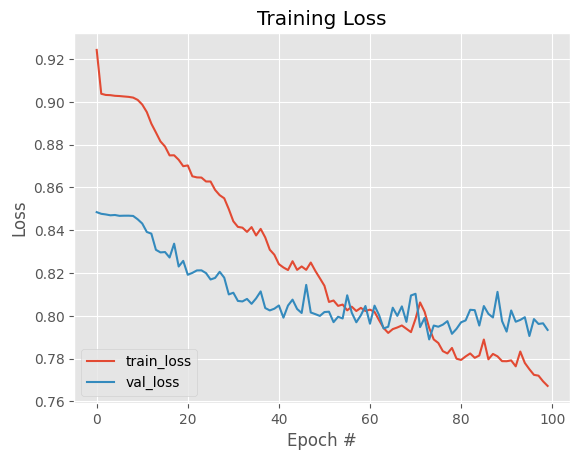

In [ ]:
# plot the training loss and accuracy
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

The training loss (depicted in red) steadily decreases as the number of epochs increases, indicating that the model is progressively improving its ability to reconstruct the input data. This consistent downward trend shows that the model is effectively minimizing the error on the training set, and by the 100th epoch, it reaches a loss value below 0.78, demonstrating solid learning performance on the training data.

The validation loss (shown in blue), which tracks the model's performance on unseen data, follows a slightly more fluctuating pattern early on. Initially, there is a small rise in the validation loss during the first 20 epochs, suggesting some instability. However, after this phase, the validation loss starts to stabilize and decrease, although it remains higher than the training loss for much of the process. This growing gap between training and validation loss, particularly after the 30th epoch, suggests that the model may be starting to overfit the training data, meaning it is becoming more specialized to the training set and less able to generalize to new data.

In conclusion, while the training process shows positive learning behavior, with both losses decreasing, the model may be slightly overfitting as indicated by the persistent gap between the two curves. This overfitting is not severe but could be addressed through regularization techniques, such as dropout or early stopping, to prevent the model from fitting too closely to the training data and to improve its generalization capabilities on the validation set.

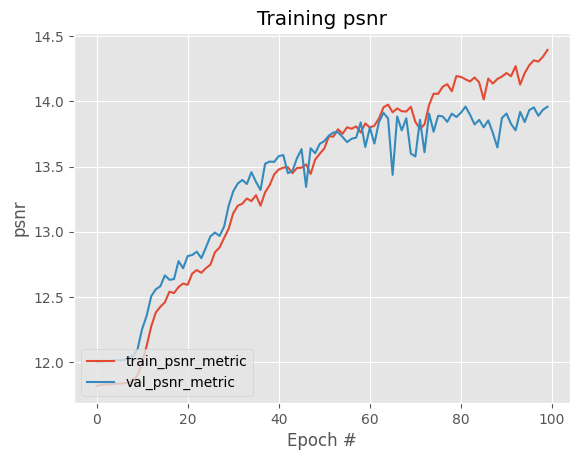

In [ ]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["psnr_metric"], label="train_psnr_metric")
plt.plot(np.arange(0, N), history.history["val_psnr_metric"], label="val_psnr_metric")
plt.title("Training psnr")
plt.xlabel("Epoch #")
plt.ylabel("psnr")
plt.legend(loc="lower left")
plt.show()

The plot above illustrates the Peak Signal-to-Noise Ratio (PSNR) metric for both the training and validation sets over 100 epochs, reflecting the autoencoder's ability to reconstruct images with less distortion. PSNR measures the quality of image reconstruction, where higher values indicate better performance.

Initially, both the training and validation PSNR values start low, at around 12.0, reflecting significant room for improvement. As training progresses, both curves show a steady upward trend, indicating that the model is consistently improving the quality of its reconstructions. By the 20th epoch, the validation PSNR (blue line) temporarily surpasses the training PSNR (red line), showing that the model generalizes well to unseen data at this stage.

After about the 40th epoch, the training PSNR consistently outperforms the validation PSNR, which starts to fluctuate slightly. These fluctuations in the validation curve suggest that the model might be slightly overfitting—learning to reconstruct training images better than unseen ones. Despite this, the validation PSNR remains relatively close to the training PSNR, indicating reasonable generalization throughout the training process.

Towards the end of the 100 epochs, the training PSNR reaches approximately 14.5, while the validation PSNR hovers just below 14.0. Overall, while the model shows solid improvements in image reconstruction quality, the slight divergence between the training and validation curves could be further mitigated with techniques like regularization to enhance generalization.

In [ ]:
# test predictions
predictions = autoencoder.predict(noisy_test_set.take(1))
predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


(20, 128, 128, 3)

(20, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(64, 128, 128, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


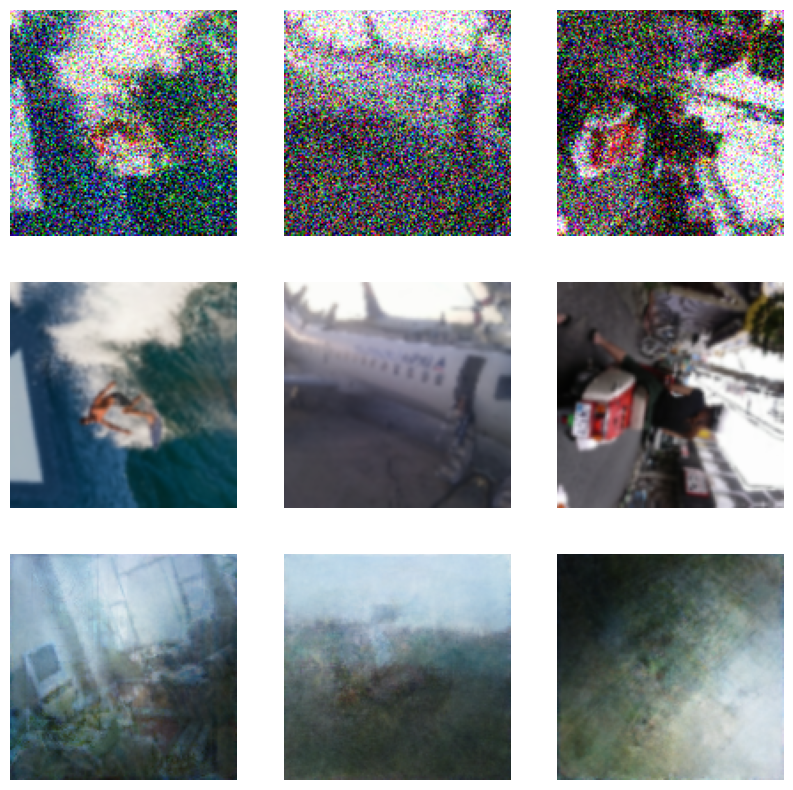

In [ ]:
# plot test set
plt.figure(figsize=(10, 10))
for X,Y in noisy_test_set.take(2):
    print(X.shape)
    for i in range(3):
        plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.axis('off')
    for i in range(3):
        plt.subplot(3, 3, i+4)
        plt.imshow(Y[i])
        plt.axis('off')
    for i in range(3):
        plt.subplot(3, 3, i+7)
        plt.imshow(autoencoder.predict(X)[i])
        plt.axis('off')
plt.show()

## Conclusion
We can see that the results aren't that good, the model is not able to denoise the images correctly. We can try to improve the model by adding more layers or by using a convolutional autoencoder, which is more suitable for image data.